# Source Injector

The source injector can produce mock simulated data independent of the MEGAlib software.

Standard data simulation requires the users to install and use MEGAlib to convolve the source model with the detector effects to generate data. The source injector utilizes the response generated by intensive simulation, which contains the statistical detector effects. With the source injector, you can convolve response, source model, and orientation to gain the mock data quickly. 

The advantages of using the source injector include:

- No need to install and use MEGAlib
- Get the data much faster than the standard simulation pipeline
- The generated data are in the format that can be used for spectral fitting, localization, imaging, etc.

The disadvantages are:

- The data are binned based on the binning of the response, which means that you lost the unbinned event distribution as you will get from the MEGAlib pipeline.
- If the response is coarse, the data you generated might not be precise.

In [1]:
%%capture
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import astropy.units as u
from pathlib import Path
from astropy.coordinates import SkyCoord
from astromodels.functions.function import Function1D, FunctionMeta
from cosipy import SpacecraftFile, SourceInjector
from histpy import Histogram
from threeML import Powerlaw, Band, Model, PointSource
from cosipy.threeml.custom_functions import SpecFromDat
from cosipy.util import fetch_wasabi_file
import shutil
import os
import h5py as h5

%matplotlib inline

In [2]:
data_dir = Path("")  # Current directory by default. Modify if you want a different path

## Get the data
The data can be downloaded by running the cells below. Each respective cell also gives the wasabi file path and file size. 

In [3]:
zipped_response_path = data_dir/"SMEXv12.Continuum.HEALPixO3_10bins_log_flat.binnedimaging.imagingresponse.nonsparse_nside8.area.good_chunks_unzip.earthocc.zip"
response_path = data_dir/"SMEXv12.Continuum.HEALPixO3_10bins_log_flat.binnedimaging.imagingresponse.nonsparse_nside8.area.good_chunks_unzip.earthocc.h5"

# download response file ~839.62 MB
fetch_wasabi_file("COSI-SMEX/DC2/Responses/SMEXv12.Continuum.HEALPixO3_10bins_log_flat.binnedimaging.imagingresponse.nonsparse_nside8.area.good_chunks_unzip.earthocc.zip", zipped_response_path, unzip = True, unzip_output = response_path, checksum = '1af13b29d7e31b56834171744406fd75')

In [4]:
%%capture
orientation_path = data_dir/"20280301_3_month_with_orbital_info.ori"

# download orientation file ~684.38 MB
fetch_wasabi_file("COSI-SMEX/DC2/Data/Orientation/20280301_3_month_with_orbital_info.ori", orientation_path)

## Inject a source response

### Method 1 : Define the point source

In this method, we are setting up an analytical function (eg: a power law model) to simulate the spectral characteristics of a point source:

In [5]:
# Defind the Crab spectrum

alpha_inj = -1.99
beta_inj = -2.32
E0_inj = 531. * (alpha_inj - beta_inj) * u.keV
xp_inj = E0_inj * (alpha_inj + 2) / (alpha_inj - beta_inj)
piv_inj = 100. * u.keV
K_inj = 7.56e-4 / u.cm / u.cm / u.s / u.keV

spectrum_inj = Band()

spectrum_inj.alpha.min_value = -2.14
spectrum_inj.alpha.max_value = 3.0
spectrum_inj.beta.min_value = -5.0
spectrum_inj.beta.max_value = -2.15
spectrum_inj.xp.min_value = 1.0

spectrum_inj.alpha.value = alpha_inj
spectrum_inj.beta.value = beta_inj
spectrum_inj.xp.value = xp_inj.value
spectrum_inj.K.value = K_inj.value
spectrum_inj.piv.value = piv_inj.value

spectrum_inj.xp.unit = xp_inj.unit
spectrum_inj.K.unit = K_inj.unit
spectrum_inj.piv.unit = piv_inj.unit

01:12:02 WARNING   The current value of the parameter beta (-2.0) was above the new maximum -2.15. ]8;id=475164;file:///Users/shengyong/conda_envs/source_injector/lib/python3.10/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=190355;file:///Users/shengyong/conda_envs/source_injector/lib/python3.10/site-packages/astromodels/core/parameter.py#794\794]8;;\

In [6]:
# Define the coordinate of the point source
source_coord = SkyCoord(l = 184.5551, b = -05.7877, frame = "galactic", unit = "deg")

# define the Crab point source
point_source = PointSource('Crab', l = source_coord.l.deg, b = source_coord.b.deg, spectral_shape=spectrum_inj)

# define the model. The model can contain multiple point sources.
model = Model(point_source)

### Read orientation file

In [7]:
# Read the 3-month orientation
# It is the pointing of the spacecraft during the the mock simlulation
ori = SpacecraftFile.parse_from_file(orientation_path)

### Get the expected counts and save to a data file

In [9]:
# Define an injector by the response
injector = SourceInjector(response_path = response_path)

CPU times: user 21.4 s, sys: 3.73 s, total: 25.1 s
Wall time: 26.4 s


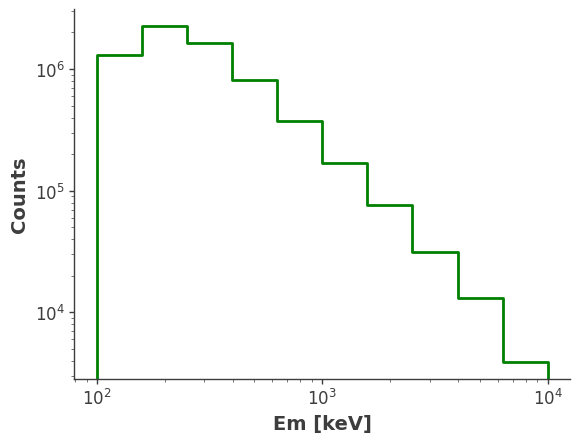

In [10]:
%%time

file_path = "Crab_model_injected.h5"

# Check if the file exists and remove it if it does
if os.path.exists(file_path):
    os.remove(file_path)

# Get the data of the injected source
model_injected = injector.inject_model(model = model, orientation = ori, make_spectrum_plot = True, data_save_path = file_path)

### Compare with Simulation

In [12]:
%%capture
# download simulated data
simulated_data_path = data_dir/"crab_3months_unbinned_data.hdf5"

# download orientation file ~89.50 MB
if not simulated_data_path.exists():
    fetch_wasabi_file("COSI-SMEX/cosipy_tutorials/source_injector/crab_3months_unbinned_data.hdf5", simulated_data_path)

Text(0.5, 1.0, 'Simulated and injected Crab')

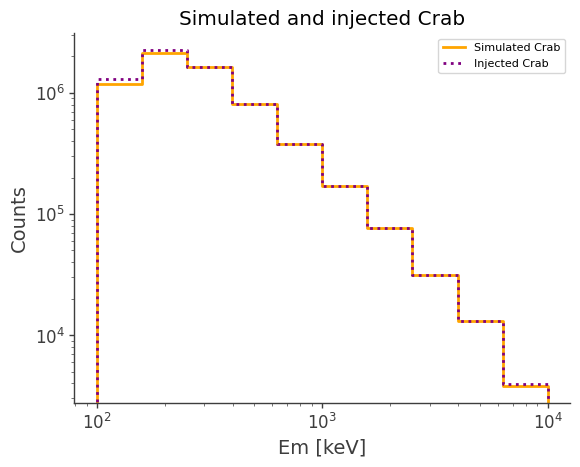

In [13]:
simulated = Histogram.open(simulated_data_path)
injected = Histogram.open("Crab_model_injected.h5")

ax,plot = simulated.project("Em").draw(label = "Simulated Crab", color = "orange")
injected.project("Em").draw(ax, label = "Injected Crab", color = "purple", linestyle = "dotted")

ax.legend()
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel("Counts")
ax.set_title("Simulated and injected Crab")

### Method 2: Read the spectrum from a file

In this method, we're loading spectral data from a file (crab_spec.dat) and visualizing it:

In [14]:
# Load data from the text file, skipping the index column
dataFlux = np.genfromtxt("crab_spec.dat",comments = "#",usecols = (2),skip_footer=1,skip_header=5)
dataEn = np.genfromtxt("crab_spec.dat",comments = "#",usecols = (1),skip_footer=1,skip_header=5)


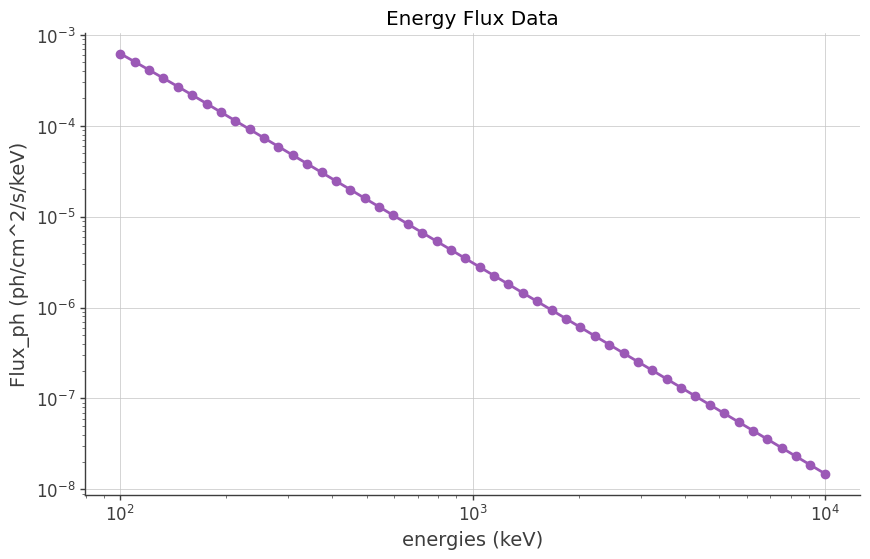

In [15]:
# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(dataEn, dataFlux, marker="o", linestyle="-")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("energies (keV)")
# plt.ylabel("Flux (keV cm^-2 s^-1)")
plt.ylabel("Flux_ph (ph/cm^2/s/keV)")
plt.title("Energy Flux Data")
plt.grid(True)
plt.show()

We use a custom class `SpecFromDat` to define a spectrum from data loaded from a CSV file `crab_spec.dat`


### SpecFromDat Class Explanation

The `SpecFromDat` class represents a spectrum loaded from a data file (`dat`, `txt`, `csv` etc.,). It provides methods to handle spectral data and evaluate the spectrum at specified energy values (`x`).

#### Class Description

- **Description**: 
  - A spectrum loaded from a data file (`dat`).

#### Parameters

- **K**:
  - **Description**: Normalization factor.
  - **Initial Value**: 1.0
  - **Is Normalization**: True
  - **Transformation**: log10
  - **Min**: 1e-30
  - **Max**: 1e3
  - **Delta**: 0.1
  - **Units**: `ph/cm2/s`

#### Properties

- **dat**:
  - **Description**: The data file from which the spectrum is loaded.
  - **Initial Value**: `test.dat`
  - **Defer**: True
  - **Units**:
    - **Energy**: `keV`.
    - **Flux**: `ph/cm2/s/keV`.
 
#### Functionality

- Loads flux (`dataFlux`) and energy (`dataEn`) from the specified data file (`self.dat.value`).
- Normalizes `dataFlux` using the widths of energy bins.
- Interpolates (`interp1d`) the normalized data to create a function (`fun`) for evaluating the spectrum.
- Evaluates the spectrum (`fun(x)`) at given energy values (`x`), scaled by the normalization factor (`K`).

In [16]:
spectrum = SpecFromDat(K=1/18, dat="crab_spec.dat")

# Define the coordinate of the point source
source_coord = SkyCoord(l = 184.5551, b = -05.7877, frame = "galactic", unit = "deg")

# define the Crab point source
point_source = PointSource('Crab', l = source_coord.l.deg, b = source_coord.b.deg, spectral_shape = spectrum)

# define the model. One model can contain multiple point sources.
model = Model(point_source)

### Read orientation file

In [17]:
# Read the 3-month orientation
# It is the pointing of the spacecraft during the the mock simlulation
ori = SpacecraftFile.parse_from_file(orientation_path)

### Get the expected counts and save to a data file

In [18]:
# Define an injector by the response
injector = SourceInjector(response_path = response_path)

CPU times: user 23.5 s, sys: 4.82 s, total: 28.3 s
Wall time: 31.1 s


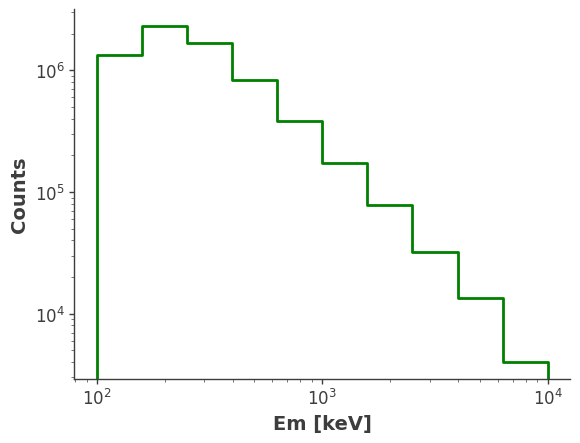

In [19]:
%%time

file_path = "crab_piecewise_injected.h5"

# Check if the file exists and remove it if it does
if os.path.exists(file_path):
    os.remove(file_path)

# Get the data of the injected source
model_injected = injector.inject_model(model = model, orientation = ori, make_spectrum_plot = True, data_save_path = file_path)

### Compare with Simulation

In [20]:
%%capture
# download simulated data
simulated_data_path = data_dir/"crab_3months_unbinned_data.hdf5"

# download orientation file ~89.50 MB
fetch_wasabi_file("COSI-SMEX/cosipy_tutorials/source_injector/crab_3months_unbinned_data.hdf5", simulated_data_path)

Text(0.5, 1.0, 'Simulated and injected Crab')

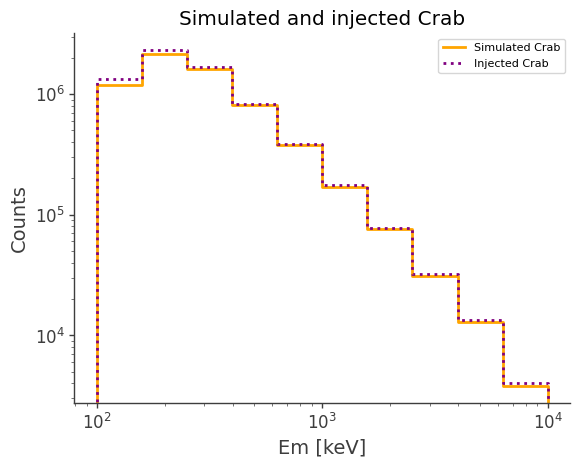

In [21]:
simulated = Histogram.open(simulated_data_path)
injected = Histogram.open("crab_piecewise_injected.h5")

ax,plot = simulated.project("Em").draw(label = "Simulated Crab", color = "orange")
injected.project("Em").draw(ax, label = "Injected Crab", color = "purple", linestyle = "dotted")

ax.legend()
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel("Counts")
ax.set_title("Simulated and injected Crab")

### (Optional) Compare simulated data with existing models

Text(0.5, 1.0, 'Comparison b/w model and piecewise injected counts')

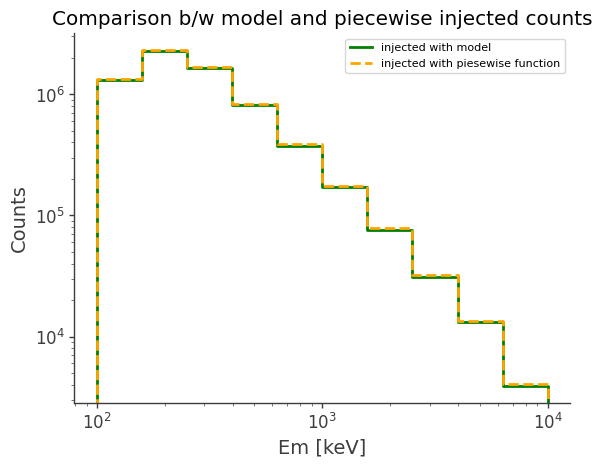

In [23]:
model_injected = Histogram.open("Crab_model_injected.h5").project("Em")
piecewise_injected = Histogram.open("crab_piecewise_injected.h5").project("Em")

ax, plot = model_injected.draw(label="injected with model", color="green")

piecewise_injected.draw(
    ax, label="injected with piesewise function", color="orange", linestyle="dashed"
)


ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()
ax.set_ylabel("Counts")
ax.set_title("Comparison b/w model and piecewise injected counts")